## 📘 Resistive Voltage Source – Theory and Derivation

A **resistive voltage source** consists of an **ideal voltage source** $ e[n] $ in series with a **resistor** $ R $.  
This composite element **can be adapted**, unlike the ideal voltage source, and is suitable for use inside a WDF connection tree.

---

### Kirchhoff-Domain Behavior

Kirchhoff's law for the series connection of a voltage source and resistor gives:

$$
v[n] - e[n] = R \cdot i[n]
$$

Solving for the port voltage:

$$
v[n] = R i[n] + e[n]
$$

---

### Wave Variable Definitions

We use:

$$
a = v + R_0 i, \quad b = v - R_0 i
$$

Using the inverse transformation:

$$
v = \frac{a + b}{2}, \quad i = \frac{a - b}{2 R_0}
$$

Substitute into the Kirchhoff equation:

$$
\frac{a + b}{2} = R \cdot \frac{a - b}{2 R_0} + e[n]
$$

Multiply both sides by 2:

$$
a + b = \frac{R}{R_0}(a - b) + 2e[n]
$$

Group terms:

$$
\left(1 + \frac{R}{R_0}\right) b = \left(\frac{R}{R_0} - 1\right) a + 2e[n]
$$

---

### Final Wave-Domain Equation

$$
\boxed{
b[n] = \frac{R - R_0}{R + R_0} a[n] + \frac{2 R_0}{R + R_0} e[n]
}
$$

This is the **unadapted case**.

---

### Matched Case: $ R = R_0 $

If we set the port resistance equal to the series resistance, then:

$$
\boxed{
b[n] = e[n]
}
$$

- The reflection term disappears
- The source is **memoryless**, **adapted**, and **numerically safe**
- This is the implementation used in `pywdf`

---

### Practical Interpretation

- This model is widely used for audio systems, where real-world sources are always resistive to some extent.
- If a circuit includes a pure ideal source, we should **manually add a small resistor** (e.g., 1 Ω) to ensure WDF compatibility.


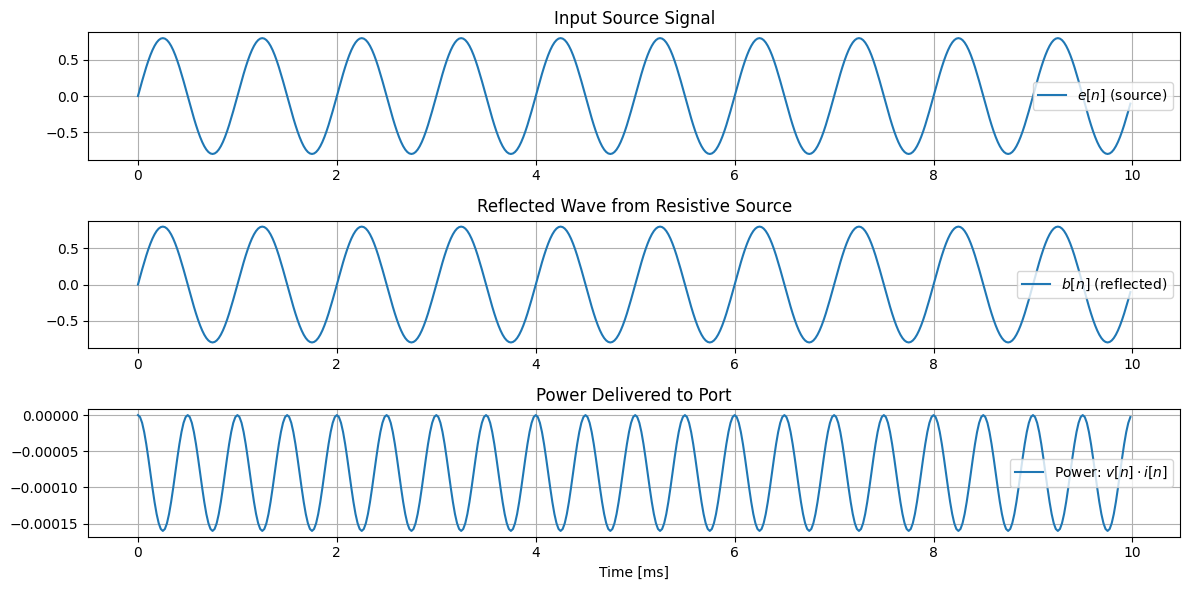

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pywdf.core.wdf import ResistiveVoltageSource

# Parameters
fs = 48000
R0 = 1000
t = np.linspace(0, 0.01, int(0.01 * fs), endpoint=False)
e = 0.8 * np.sin(2 * np.pi * 1000 * t)  # Source voltage

# Create resistive voltage source (matched)
source = ResistiveVoltageSource(R0)

a_vals, b_vals, v_vals, i_vals, power_vals = [], [], [], [], []

for e_n in e:
    source.set_voltage(e_n)

    # Input wave a[n]
    a = 0.0  # No incoming wave in root case
    source.accept_incident_wave(a)
    b = source.propagate_reflected_wave()

    # Recover physical variables
    v = (a + b) / 2
    i = (a - b) / (2 * R0)
    power = v * i

    a_vals.append(a)
    b_vals.append(b)
    v_vals.append(v)
    i_vals.append(i)
    power_vals.append(power)

# Plot
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(t * 1000, e, label="$e[n]$ (source)")
plt.title("Input Source Signal")
plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(t * 1000, b_vals, label="$b[n]$ (reflected)")
plt.title("Reflected Wave from Resistive Source")
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(t * 1000, power_vals, label="Power: $v[n] \cdot i[n]$")
plt.title("Power Delivered to Port")
plt.legend()
plt.grid()
plt.xlabel("Time [ms]")

plt.tight_layout()
plt.show()
